# Part 1. Create base grid with H3

### Import necessary modules

In [1]:
# Spatial
import geopandas as gpd
from geopandas.tools import sjoin

# Mapping / Plotting
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
import config

### Define area of interest

In [3]:
area = config.AREA_OF_INTEREST

In [4]:
print(area)

COUNTRY


### Functions for creating heaxgons

In [5]:
from create_hex import*

### Import layers to be used

In [6]:
## admininstrative boundary
if area == "COUNTRY":
    admin_gdf = gpd.read_file(config.ADMIN_PATH / config.ADMIN_GPKG, layer=config.ADMIN_LAYER_COUNTRY)
    region_gdf = gpd.read_file(config.ADMIN_PATH / config.ADMIN_GPKG, layer=config.ADMIN_LAYER_REGION)
else:    
    region_gdf = gpd.read_file(config.ADMIN_PATH / config.ADMIN_GPKG, layer=config.ADMIN_LAYER_REGION)
    region_gdf = region_gdf[region_gdf[region_col_name]==area]
    admin_gdf = region_gdf

In [7]:
print(admin_gdf.crs)

EPSG:4326


### H3 - Hexagon - grid

In [8]:
size = config.HEX_SIZE ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = feat(admin_gdf, size)
hexagons.to_file(config.OUTPUT_DIR / "hex.geojson")

In [9]:
# # Plot basemap
# fig, ax = plt.subplots(figsize=(25, 15))
# hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
# admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
# ax.set_aspect('equal', 'box')

# # Save plot as figure 
# #plt.savefig('admin level basemap.png', bbox_inches='tight')

In [10]:
# Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, region_gdf[[config.ADMIN_REGION_COLUMN_NAME, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[config.ADMIN_REGION_COLUMN_NAME].notnull()]
hexagons = hexagons.drop(columns=['index_right'])

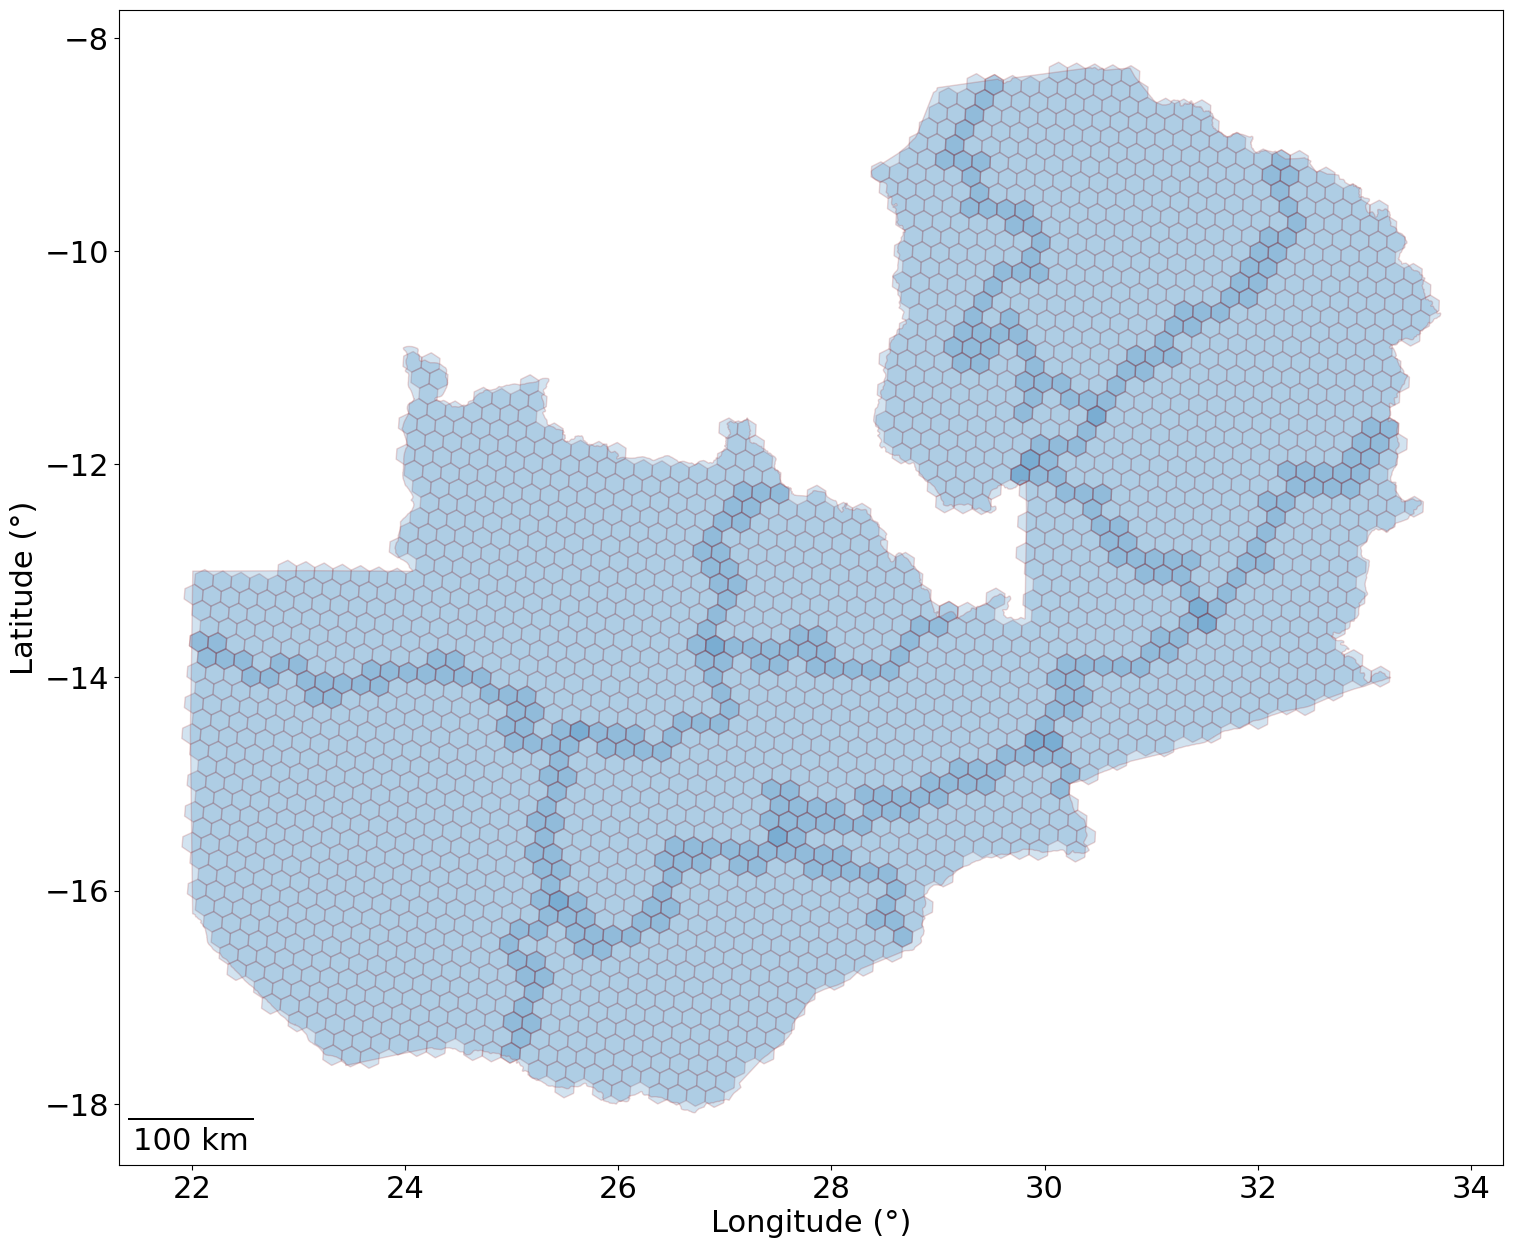

In [11]:
# Plot basemap
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(25, 15))
# fig, ax = plt.subplots(figsize=(4, 3))


# hex_reproj = hexagons.to_crs(32619)  # Convert the dataset to a coordinate
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
assert admin_gdf.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(config.OUTPUT_DIR / 'admin_level_basemap.png', bbox_inches='tight')

#### Select base map grid

In [12]:
hexagons['id'] = range(1, len(hexagons)+1)

In [13]:
hexagons.head(3)

,geometry,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id
0,"POLYGON ((27.47639 -14.37042, 27.48221 -14.273...",85962ac7fffffff,2047,571,1554,995,198,1253,0,Central,1
1,"POLYGON ((28.72507 -15.46173, 28.73041 -15.364...",859623abfffffff,1013,400,388,2175,1146,2483,1,Lusaka,2
2,"POLYGON ((27.7189 -13.21302, 27.72459 -13.1157...",85960107fffffff,1394,2113,2439,531,456,1488,2,Copperbelt,3


In [14]:
hexagons.columns

Index(['geometry', 'h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index',
       'NAME_1', 'id'],
      dtype='object')

In [15]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(config.OUTPUT_DIR / f'h3_grid_at_hex_{size}.shp', index=False)
hexagons.to_file(config.OUTPUT_DIR / config.H3_GRID_HEX_SHP, index=False) # file used in the other scripts
admin_gdf.to_file(config.OUTPUT_DIR / f'area_gdf.gpkg', index=False)
admin_gdf.to_file(config.OUTPUT_DIR  / f'area_gdf.geojson', driver='GeoJSON', index=False) 